# Bitcoin Price Prediction

In this notebook, we predict the price of the bitcoin in the future, given the historical trends of the prices of bitcoin from the past 7-8 years.

The data for this project is taken from - https://www.coindesk.com/price/bitcoin/

## Check GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-e5d27ffc-7fbb-20e5-5f0b-6415704fe66b)


## Get Data

In [ ]:
# Import data with pandas
import pandas as pd
# Let's check our bitcoin data and parse the dates since it's a time series problem
df = pd.read_csv("BTC_USD_2014-11-02_2021-11-30-CoinDesk.csv", 
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is datetime

# Check the dataframe
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-02,BTC,325.22633,338.01050,338.12950,319.36700
2014-11-03,BTC,331.60083,325.22633,333.75983,319.04350
2014-11-04,BTC,324.71833,331.60083,332.75133,323.06333
2014-11-05,BTC,332.45666,324.71833,335.81166,320.93333
2014-11-06,BTC,336.58500,332.45666,341.49000,328.56166


In [ ]:
# Check the number of samples we have
len(df)

2581

We've collected data samples of Bitcoin for the past 7 years but there are only 2581 samples.

Deep Learning model like a big chunk of data to work efficiently but in time series problems we will often see there are a small number of examples for the dataset

In [ ]:
# We only want the closing price of the bitcoin data
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices

,Price
Date,
2014-11-02,325.226330
2014-11-03,331.600830
2014-11-04,324.718330
2014-11-05,332.456660
2014-11-06,336.585000
...,...
2021-11-26,58890.528335
2021-11-27,54304.128195
2021-11-28,54877.475347


Plot the bitcoin prices data

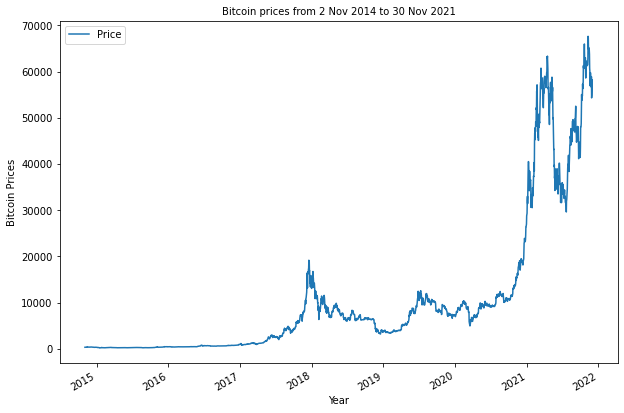

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("Bitcoin Prices")
plt.xlabel("Year")
plt.title("Bitcoin prices from 2 Nov 2014 to 30 Nov 2021", fontsize=10);

## Make Windowed Datasets

In [ ]:
# Setup global variables for window size and horizon
HORIZON = 1 # predict 1 day
WINDOW_SIZE = 7 # use data of last 7 days to predict horizon

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset

  Example : if horizon=1 then
  Input = [1, 2, 3, 4, 5, 6, 7, 8] -> Output = ([1, 2, 3, 4, 5, 6, 7], [8])
  """
  return x[:,:-horizon],x[:,-horizon:]

In [ ]:
import numpy as np
# Create function to view Numpy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array to a 2D array of sequential labelled windows with window_size and horizon size labels
  """
  # 1. Create a window of specific window_size (add the horizon at the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window Indexes : \n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  
  return windows,labels

In [ ]:
# Create a list of bitcoin prices from the datasets
prices = bitcoin_prices.Price.to_numpy()
prices[:10]

array([325.22633, 331.60083, 324.71833, 332.45666, 336.585  , 346.775  ,
       344.81166, 343.065  , 358.50166, 368.07666])

In [ ]:
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2574, 2574)

In [ ]:
# Check shapes
full_windows.shape, full_labels.shape

((2574, 7), (2574, 1))

In [ ]:
# Make train and test splits
def make_test_splits(windows,labels,test_split=0.2):
  """
  Make train and test sets for windows and labels.
  """
  split_size = int(len(windows) * (1-test_split)) # Default 80% training data/ 20% testing data 
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_test_splits(full_windows,full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2059, 515, 2059, 515)

In [ ]:
train_windows[:10], train_labels[:10]

(array([[325.22633, 331.60083, 324.71833, 332.45666, 336.585  , 346.775  ,
         344.81166],
        [331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
         343.065  ],
        [324.71833, 332.45666, 336.585  , 346.775  , 344.81166, 343.065  ,
         358.50166],
        [332.45666, 336.585  , 346.775  , 344.81166, 343.065  , 358.50166,
         368.07666],
        [336.585  , 346.775  , 344.81166, 343.065  , 358.50166, 368.07666,
         376.99666],
        [346.775  , 344.81166, 343.065  , 358.50166, 368.07666, 376.99666,
         442.10666],
        [344.81166, 343.065  , 358.50166, 368.07666, 376.99666, 442.10666,
         389.00333],
        [343.065  , 358.50166, 368.07666, 376.99666, 442.10666, 389.00333,
         394.92666],
        [358.50166, 368.07666, 376.99666, 442.10666, 389.00333, 394.92666,
         377.08   ],
        [368.07666, 376.99666, 442.10666, 389.00333, 394.92666, 377.08   ,
         400.47166]]), array([[343.065  ],
        [358.50166

In [ ]:
test_windows[:10], test_labels[:10]

(array([[9680.9471279 , 9609.68024553, 9311.13631832, 9252.63337177,
         9171.73208577, 9022.153768  , 9101.85005736],
        [9609.68024553, 9311.13631832, 9252.63337177, 9171.73208577,
         9022.153768  , 9101.85005736, 9188.06137546],
        [9311.13631832, 9252.63337177, 9171.73208577, 9022.153768  ,
         9101.85005736, 9188.06137546, 9148.44485856],
        [9252.63337177, 9171.73208577, 9022.153768  , 9101.85005736,
         9188.06137546, 9148.44485856, 9236.31677043],
        [9171.73208577, 9022.153768  , 9101.85005736, 9188.06137546,
         9148.44485856, 9236.31677043, 9097.79736639],
        [9022.153768  , 9101.85005736, 9188.06137546, 9148.44485856,
         9236.31677043, 9097.79736639, 9094.32456102],
        [9101.85005736, 9188.06137546, 9148.44485856, 9236.31677043,
         9097.79736639, 9094.32456102, 9124.6535344 ],
        [9188.06137546, 9148.44485856, 9236.31677043, 9097.79736639,
         9094.32456102, 9124.6535344 , 9055.46448252],
        

## Make a modelling checkpoint

In [ ]:
import tensorflow as tf
checkpoint_path = "model_checkpoints/model_1.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

## Build a basic model for the bitcoin prediction

In [ ]:
from tensorflow.keras import layers

# 1. Construct a model
model_1 = tf.keras.Sequential([
  layers.Dense(512, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
],name="model_1")

# 2. Compile our model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[model_checkpoint])

Epoch 1/100
 1/17 [>.............................] - ETA: 25s - loss: 5009.5757 - mae: 5009.5757 - mse: 49527696.0000
Epoch 00001: val_loss improved from inf to 5573.77197, saving model to model_checkpoints/model_1.ckpt
17/17 [==============================] - 2s 15ms/step - loss: 1901.9231 - mae: 1901.9231 - mse: 11130386.0000 - val_loss: 5573.7720 - val_mae: 5573.7720 - val_mse: 46873340.0000
Epoch 2/100
 1/17 [>.............................] - ETA: 0s - loss: 703.9582 - mae: 703.9582 - mse: 1016193.2500
Epoch 00002: val_loss improved from 5573.77197 to 2961.74707, saving model to model_checkpoints/model_1.ckpt
17/17 [==============================] - 0s 5ms/step - loss: 413.1697 - mae: 413.1697 - mse: 491451.4688 - val_loss: 2961.7471 - val_mae: 2961.7471 - val_mse: 16242808.0000
Epoch 3/100
 1/17 [>.............................] - ETA: 0s - loss: 428.9841 - mae: 428.9841 - mse: 457820.4375
Epoch 00003: val_loss improved from 2961.74707 to 1693.37231, saving model to model_checkpoin

In [ ]:
# Load the best weights
model_1.load_weights(checkpoint_path)

In [ ]:
# Evaluate on full dataset
model_1.evaluate(test_windows,test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1002.9640 - mae: 1002.9640 - mse: 2306467.2500


[1002.9639892578125, 1002.9639892578125, 2306467.25]

In [ ]:
# Make predictions
model_1_preds = model_1.predict(test_windows)

## Make a function to evaluate our model predictions

In [ ]:
# MASE Implementation
def mean_absolute_scaled_error(y_true,y_preds):
  """
  Implement MASE provided no seasonality of data is there
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_preds))

  # Find MAE of naive forecast
  mae_naive_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_seasonality

In [ ]:
# Create a function to evaluate all evaluation metrics
def calculate_results_time_series(y_true,y_preds):
  """
  Returns a dictionary of MAE, MSE, RMSE, MAPE, MASE metrics for evaluation
  """
  # Make sure the data is in float32 format
  y_true = tf.cast(y_true, tf.float32)
  y_preds = tf.cast(y_preds, tf.float32)
  
  # Calculate different evaluation scores
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_preds)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_preds)
  rmse = tf.math.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_preds)
  mase = mean_absolute_scaled_error(y_true, y_preds)
  
  # Check for different horizons by checking the ndims
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"MAE":mae.numpy(),
          "MSE": mse.numpy(),
          "RMSE": rmse.numpy(),
          "MAPE": mape.numpy(),
          "MASE": mase.numpy()}

In [ ]:
# Evaluate our predictions
model_1_results = calculate_results_time_series(tf.squeeze(test_labels), tf.squeeze(model_1_preds))
model_1_results

{'MAE': 1002.96405,
 'MAPE': 2.6769154,
 'MASE': 1.0043349,
 'MSE': 2306467.2,
 'RMSE': 1518.7058}

## Create a function to plot our time series data

In [ ]:
# Create a function to visualize time series
def plot_time_series(timesteps,values,format=".",start=0,end=None,label=None):
  """
  Plots timesteps vs values (values across timesteps)

  Parameters
  -----------
  timesteps: array of timesteps values
  values: array of values across timesteps
  format: type of graph, eg - . for scatter, - for line, default = .
  start: start of plot - setting a value will index from the particular timestep
  end: end of plot - setting a value will end the plot at particular timestep
  label: a label to show plot about the values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Bitcoin Price")
  if label:
    plt.legend(fontsize=14); # make label bigger
  plt.grid(True);

In [ ]:
# Get timesteps of our dataset
timesteps = bitcoin_prices.index.to_numpy()
timesteps

array(['2014-11-02T00:00:00.000000000', '2014-11-03T00:00:00.000000000',
       '2014-11-04T00:00:00.000000000', ...,
       '2021-11-28T00:00:00.000000000', '2021-11-29T00:00:00.000000000',
       '2021-11-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
# Create train and test splits for our dataset 
split_size = int(0.8 * len(prices))
split_size

# Splitting the datasets by indexing
X_train = timesteps[:split_size]
X_test = timesteps[split_size:]
y_train = prices[:split_size]
y_test = prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2064,), (517,), (2064,), (517,))

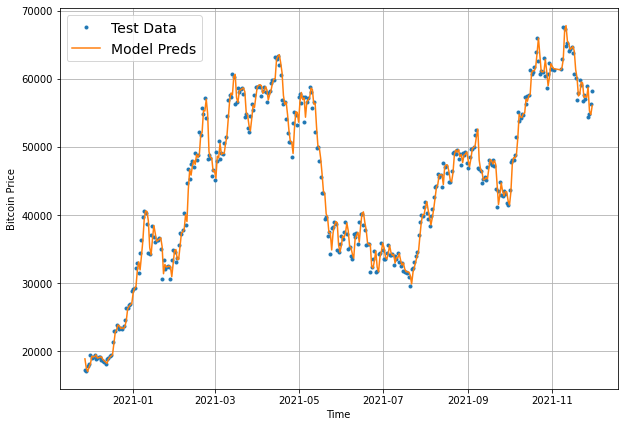

In [ ]:
# Let's plot our predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=150,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds[:,0],
                 start=150,
                 label="Model Preds",
                 format="-");

## Build a model using a Conv1D layer

A conv1D layer takes a shape of : `(batch_size, timesteps, input_dim)`

So we need to shape our data accordingly

In [ ]:
# Model Checkpoint
checkpoint_path = "model_checkpoints/model_2.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [ ]:
# Structure model
model_2 = tf.keras.Sequential([
  layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=512,
                kernel_size=5,
                padding="causal",
                strides=1,
                activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_conv1D")

# Compile model
model_2.compile(loss=["mae"],
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[model_checkpoint])

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 1520.6958 - mae: 1520.6958 - mse: 7302380.5000   
Epoch 00001: val_loss improved from inf to 3521.19751, saving model to model_checkpoints/model_2.ckpt
17/17 [==============================] - 7s 21ms/step - loss: 1520.6958 - mae: 1520.6958 - mse: 7302380.5000 - val_loss: 3521.1975 - val_mae: 3521.1975 - val_mse: 22272612.0000
Epoch 2/100
15/17 [=========================>....] - ETA: 0s - loss: 339.0493 - mae: 339.0493 - mse: 389905.6875
Epoch 00002: val_loss improved from 3521.19751 to 2032.45544, saving model to model_checkpoints/model_2.ckpt
17/17 [==============================] - 0s 7ms/step - loss: 339.5009 - mae: 339.5009 - mse: 393764.8125 - val_loss: 2032.4554 - val_mae: 2032.4554 - val_mse: 8657139.0000
Epoch 3/100
16/17 [===========================>..] - ETA: 0s - loss: 259.6993 - mae: 259.6993 - mse: 248813.1250
Epoch 00003: val_loss improved from 2032.45544 to 1890.38831, saving model to model_checkpoints

In [ ]:
# Load in best weights
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate on full test set
model_2.evaluate(test_windows,test_labels)

17/17 [==============================] - 0s 3ms/step - loss: 1004.8165 - mae: 1004.8165 - mse: 2307650.5000


[1004.8164672851562, 1004.8164672851562, 2307650.5]

In [ ]:
# Make predictions
model_2_preds = model_2.predict(test_windows)

In [ ]:
# Evaluate our predictions
model_2_results = calculate_results_time_series(tf.squeeze(test_labels), tf.squeeze(tf.squeeze(model_2_preds)))
model_2_results

{'MAE': 1004.8164,
 'MAPE': 2.6864586,
 'MASE': 1.0061898,
 'MSE': 2307650.5,
 'RMSE': 1519.0952}

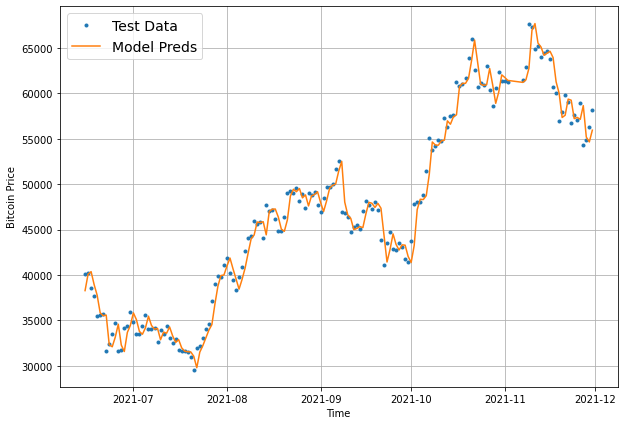

In [ ]:
# Plot our predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=350,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds[:,:,0],
                 start=350,
                 label="Model Preds",
                 format="-");

## Add block reward column to the bitcoin dataset

To learn about bitcoin block reward check out - https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [ ]:
import numpy as np
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 (this block reward isnt in our dataset)
block_reward_2 = 25 # 28 November 2012 (this block reward isn't in our dataset)
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward Dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward_values should be 
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_2_days

615

In [ ]:
# Similarly doing for others
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_3_days

2024

In [ ]:
# Add in block_reward column to our dataframe
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
bitcoin_prices_block.block_reward[:block_reward_2_days] = block_reward_2
bitcoin_prices_block.block_reward[block_reward_2_days:block_reward_3_days] = block_reward_3
bitcoin_prices_block.block_reward[block_reward_3_days:] = block_reward_4
bitcoin_prices_block

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Price,block_reward
Date,,
2014-11-02,325.226330,25
2014-11-03,331.600830,25
2014-11-04,324.718330,25
2014-11-05,332.456660,25
2014-11-06,336.585000,25
...,...,...
2021-11-26,58890.528335,6.25
2021-11-27,54304.128195,6.25
2021-11-28,54877.475347,6.25


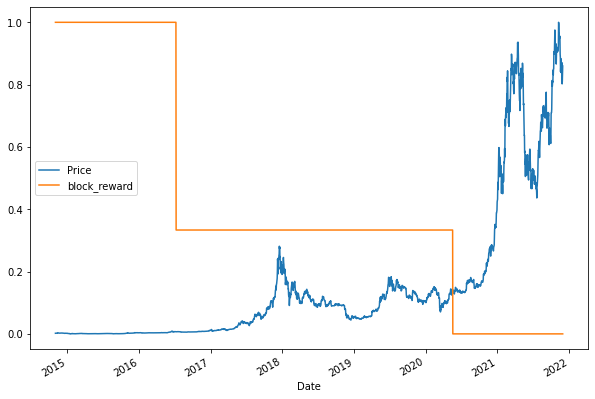

In [ ]:
# Plot the dataframe with the same scale
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

## Make windowed datasets with pandas

In [ ]:
# Setup data parameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the dataset
bitcoin_prices_windowed = bitcoin_prices_block.copy()

In [ ]:
# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_block["Price"].shift(periods=i+1)

# Check the windowed dataframe
bitcoin_prices_windowed.head(15)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-11-02,325.22633,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,331.60083,25,325.22633,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,25,331.60083,325.22633,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,25,324.71833,331.60083,325.22633,NaN,NaN,NaN,NaN
2014-11-06,336.58500,25,332.45666,324.71833,331.60083,325.22633,NaN,NaN,NaN
2014-11-07,346.77500,25,336.58500,332.45666,324.71833,331.60083,325.22633,NaN,NaN
2014-11-08,344.81166,25,346.77500,336.58500,332.45666,324.71833,331.60083,325.22633,NaN
2014-11-09,343.06500,25,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083,325.22633
2014-11-10,358.50166,25,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083


In [ ]:
# Drop rows with empty values
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-09,25.0,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830,325.226318
2014-11-10,25.0,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830
2014-11-11,25.0,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323
2014-11-12,25.0,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665
2014-11-13,25.0,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991


In [ ]:
y.head()

Date
2014-11-09    343.065002
2014-11-10    358.501648
2014-11-11    368.076660
2014-11-12    376.996674
2014-11-13    442.106659
Name: Price, dtype: float32

In [ ]:
# Make train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2059, 2059, 515, 515)

In [ ]:
# Create model checkpoint
checkpoint_path = "model_checkpoints/model_3.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [ ]:
# Create model
model_3 = tf.keras.Sequential([
  layers.Dense(512, activation="relu"),
  layers.Dense(512, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3")

# Compile the model
model_3.compile(loss=["mae"],
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# Fit the model
model_3.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test,y_test),
            callbacks=[model_checkpoint])

Epoch 1/100
 1/17 [>.............................] - ETA: 5s - loss: 3723.2773 - mae: 3723.2773 - mse: 24163520.0000
Epoch 00001: val_loss improved from inf to 3726.22314, saving model to model_checkpoints/model_3.ckpt
17/17 [==============================] - 1s 14ms/step - loss: 725.2643 - mae: 725.2643 - mse: 2323918.2500 - val_loss: 3726.2231 - val_mae: 3726.2231 - val_mse: 21139114.0000
Epoch 2/100
 1/17 [>.............................] - ETA: 0s - loss: 499.5880 - mae: 499.5880 - mse: 573874.6875
Epoch 00002: val_loss improved from 3726.22314 to 1838.77844, saving model to model_checkpoints/model_3.ckpt
17/17 [==============================] - 0s 5ms/step - loss: 275.0506 - mae: 275.0506 - mse: 253237.0469 - val_loss: 1838.7784 - val_mae: 1838.7784 - val_mse: 6052910.0000
Epoch 3/100
 1/17 [>.............................] - ETA: 0s - loss: 227.2670 - mae: 227.2670 - mse: 173761.0156
Epoch 00003: val_loss improved from 1838.77844 to 1302.12415, saving model to model_checkpoints/mod

In [ ]:
# Load in best weights
model_3.load_weights(checkpoint_path)

In [ ]:
# Evaluate on test set
model_3.evaluate(X_test,y_test)

17/17 [==============================] - 0s 2ms/step - loss: 999.5573 - mae: 999.5573 - mse: 2288837.0000


[999.5572509765625, 999.5572509765625, 2288837.0]

In [ ]:
# Make predictions
model_3_preds = model_3.predict(X_test)

In [ ]:
# Evaluate our predictions
model_3_results = calculate_results_time_series(y_test, tf.squeeze(model_3_preds))
model_3_results

{'MAE': 999.5572,
 'MAPE': 2.6655247,
 'MASE': 1.0009234,
 'MSE': 2288837.0,
 'RMSE': 1512.8903}

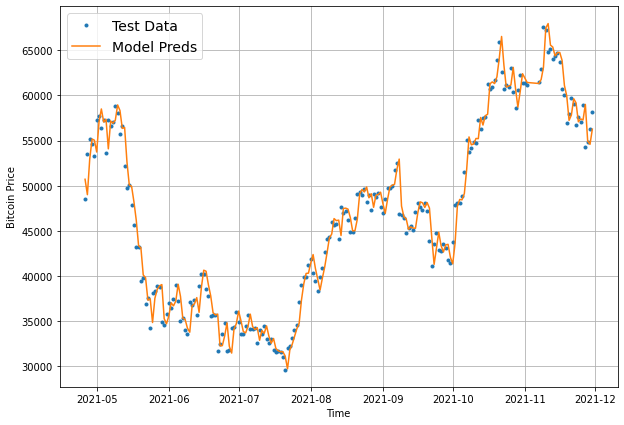

In [ ]:
# Plot our predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=y_test[:],
                 start=300,
                 label="Test Data")
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=model_3_preds[:,0],
                 start=300,
                 label="Model Preds",
                 format="-");

### Add the feature of day of week as a column to our dataset

In [ ]:
import datetime

In [ ]:
# Creating a day of week feature 
X['day_of_week'] = X.index.dayofweek
X.head(10)

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,day_of_week
Date,,,,,,,,,
2014-11-09,25.0,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830,325.226318,6
2014-11-10,25.0,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830,0
2014-11-11,25.0,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323,1
2014-11-12,25.0,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665,2
2014-11-13,25.0,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991,3
2014-11-14,25.0,442.106659,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994,4
2014-11-15,25.0,389.003326,442.106659,376.996674,368.076660,358.501648,343.065002,344.811646,5
2014-11-16,25.0,394.926666,389.003326,442.106659,376.996674,368.076660,358.501648,343.065002,6
2014-11-17,25.0,377.079987,394.926666,389.003326,442.106659,376.996674,368.076660,358.501648,0


In [ ]:
# Make train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2059, 2059, 515, 515)

In [ ]:
# Create model checkpoint
checkpoint_path = "model_checkpoints/model_4.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [ ]:
# Create model
model_4 = tf.keras.Sequential([
  layers.Dense(512, activation="relu"),
  layers.Dense(512, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(HORIZON)
], name="model_4")

# Compile the model
model_4.compile(loss=["mae"],
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# Fit the model
model_4.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test,y_test),
            callbacks=[model_checkpoint])

Epoch 1/100
 1/17 [>.............................] - ETA: 6s - loss: 4510.7617 - mae: 4510.7617 - mse: 37465508.0000
Epoch 00001: val_loss improved from inf to 2436.43604, saving model to model_checkpoints/model_4.ckpt
17/17 [==============================] - 1s 14ms/step - loss: 1381.6904 - mae: 1381.6904 - mse: 6411875.0000 - val_loss: 2436.4360 - val_mae: 2436.4360 - val_mse: 11940144.0000
Epoch 2/100
 1/17 [>.............................] - ETA: 0s - loss: 272.1518 - mae: 272.1518 - mse: 211295.9375
Epoch 00002: val_loss improved from 2436.43604 to 2423.27832, saving model to model_checkpoints/model_4.ckpt
17/17 [==============================] - 0s 6ms/step - loss: 304.0804 - mae: 304.0804 - mse: 303953.1250 - val_loss: 2423.2783 - val_mae: 2423.2783 - val_mse: 10093239.0000
Epoch 3/100
 1/17 [>.............................] - ETA: 0s - loss: 365.5634 - mae: 365.5634 - mse: 375815.5625
Epoch 00003: val_loss improved from 2423.27832 to 1600.90308, saving model to model_checkpoints/

In [ ]:
# Load in best weights
model_4.load_weights(checkpoint_path)

In [ ]:
# Evaluate on test set
model_4.evaluate(X_test,y_test)

17/17 [==============================] - 0s 2ms/step - loss: 994.9489 - mae: 994.9489 - mse: 2272665.5000


[994.9488525390625, 994.9488525390625, 2272665.5]

In [ ]:
# Make predictions
model_4_preds = model_4.predict(X_test)

In [ ]:
# Calculate model results
model_4_results = calculate_results_time_series(y_test,tf.squeeze(model_4_preds))
model_4_results

{'MAE': 994.9488,
 'MAPE': 2.6572206,
 'MASE': 0.9963087,
 'MSE': 2272665.5,
 'RMSE': 1507.5363}

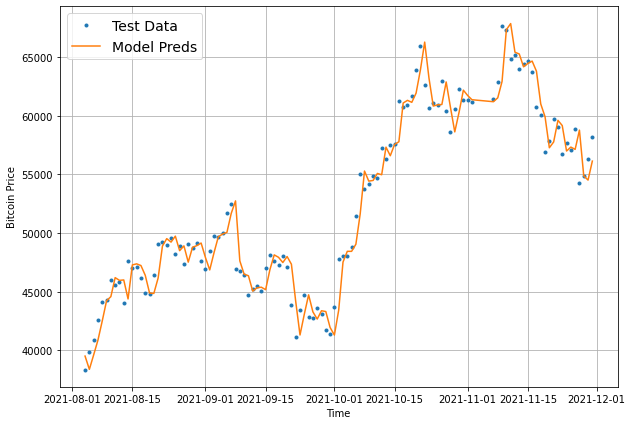

In [ ]:
# Plot predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=y_test[:],
                 start=400,
                 label="Test Data")
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=model_4_preds[:,0],
                 start=400,
                 label="Model Preds",
                 format="-");

## N-BEATS Algorithm - Neural Basis Expansion Analysis for Interpretable Time Series Forecasting

We will try to replicate the model architecture from figure 1 of the paper : https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and model in TensorFlow we can use subclassing.

In [127]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs takes care of all the arguments of the parent class (input_shape, trainable, name, etc) 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers and has relu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # How to go from inputs to outputs
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from the theta layer
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [135]:
# Create dataset 
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-02,325.22633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,331.60083,325.22633,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,331.60083,325.22633,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,324.71833,331.60083,325.22633,NaN,NaN,NaN,NaN
2014-11-06,336.58500,332.45666,324.71833,331.60083,325.22633,NaN,NaN,NaN
2014-11-07,346.77500,336.58500,332.45666,324.71833,331.60083,325.22633,NaN,NaN
2014-11-08,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083,325.22633,NaN
2014-11-09,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083,325.22633
2014-11-10,358.50166,343.06500,344.81166,346.77500,336.58500,332.45666,324.71833,331.60083


In [136]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

X

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2014-11-09,344.811660,346.775000,336.585000,332.456660,324.718330,331.600830,325.226330
2014-11-10,343.065000,344.811660,346.775000,336.585000,332.456660,324.718330,331.600830
2014-11-11,358.501660,343.065000,344.811660,346.775000,336.585000,332.456660,324.718330
2014-11-12,368.076660,358.501660,343.065000,344.811660,346.775000,336.585000,332.456660
2014-11-13,376.996660,368.076660,358.501660,343.065000,344.811660,346.775000,336.585000
...,...,...,...,...,...,...,...
2021-11-26,57055.583345,57653.986829,56713.258063,59023.259799,59756.024151,57896.166603,56936.516170
2021-11-27,58890.528335,57055.583345,57653.986829,56713.258063,59023.259799,59756.024151,57896.166603
2021-11-28,54304.128195,58890.528335,57055.583345,57653.986829,56713.258063,59023.259799,59756.024151


In [137]:
# Make train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2059, 2059, 515, 515)

In [138]:
X_train.shape, y_train.shape

((2059, 7), (2059,))

In [139]:
# Time to make our dataset performant using the tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features and labels by zipping
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch (batch size = 1024 was taken from the paper for nbeats algorithm)
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for our N-Beats algorithm

Many of the hyperparameters can be found on Table 18 in the paper -  https://arxiv.org/pdf/1905.10437.pdf

In [140]:
# Values from N-Beats Paper 
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
WINDOW_SIZE = 7
HORIZON = 1

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON

In [141]:
# Build the N-BEATS model

# 1. Setup the instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="IntialBlock")

# 2. Create an input layer to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is the Intial Block so that's why we subtract 1
  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals,backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast,block_forecast], name=f"add_{i}")

# 7. Put together the N-BEATS stack model
model_5 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model")

# 8. Compile the model
model_5.compile(loss=["mae"],
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae","mse"])

# 9. Fit the model
model_5.fit(X_train,y_train,
            epochs=N_EPOCHS,
            validation_data=(X_test,y_test),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=200,restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=100, verbose=1)])


Epoch 00164: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [142]:
# Evaluate on test dataset
model_5.evaluate(test_dataset)

1/1 [==============================] - 50s 50s/step - loss: 993.7640 - mae: 993.7640 - mse: 2277885.2500


[993.7640380859375, 993.7640380859375, 2277885.25]

In [144]:
# Make predictions
model_5_preds = model_5.predict(test_dataset)

In [146]:
# Calculate results
model_5_results = calculate_results_time_series(y_test, tf.squeeze(model_5_preds))
model_5_results

{'MAE': 993.76404,
 'MAPE': 2.6567447,
 'MASE': 0.9951223,
 'MSE': 2277885.2,
 'RMSE': 1509.2665}

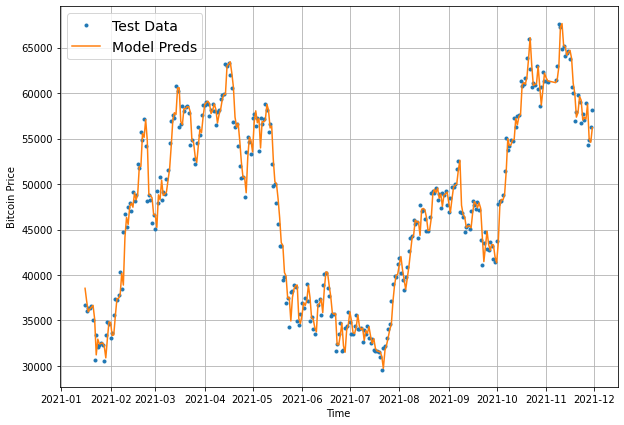

In [148]:
# Plot predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=y_test[:],
                 start=200,
                 label="Test Data")
plot_time_series(timesteps=timesteps[-len(X_test):],
                 values=model_5_preds[:,0],
                 start=200,
                 label="Model Preds",
                 format="-");

### Plotting the N-BEATS Model

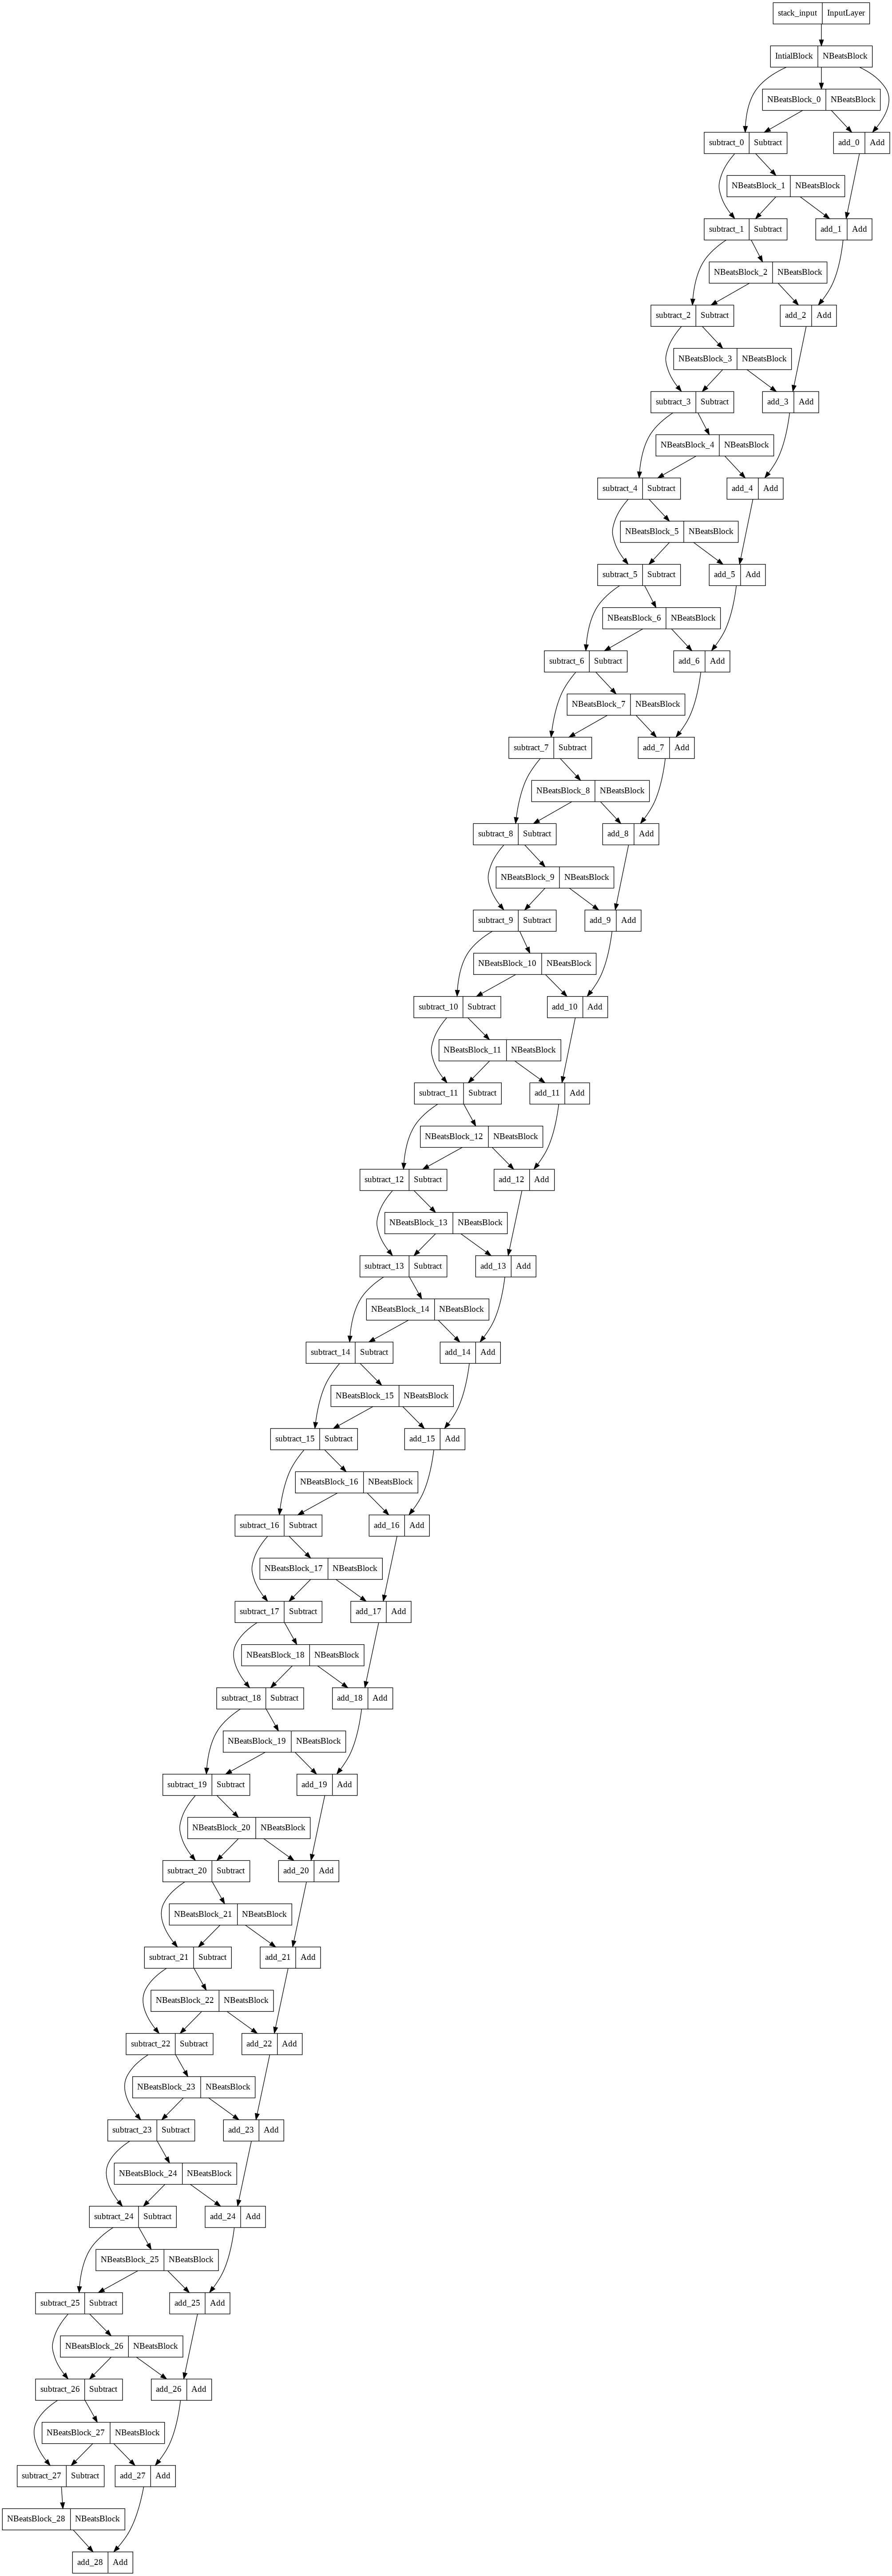

In [149]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

## Train a model on full dataset

Since our N-BEATS model has performed the best we will train the full data on it

In [150]:
# Train model on whole data to make predictions the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price","block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"]

len(X_all), len(y_all)

(2574, 2574)

In [152]:
# Turn our data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Prefetch and batch
dataset_all = dataset_all.batch(1024).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [153]:
# Create model checkpoint
checkpoint_path = "model_checkpoints/model_6.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

In [155]:
# Build the N-BEATS model

# 1. Setup the instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="IntialBlock")

# 2. Create an input layer to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is the Intial Block so that's why we subtract 1
  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals,backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast,block_forecast], name=f"add_{i}")

# 7. Put together the N-BEATS stack model
model_6 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model")

# 8. Compile the model
model_6.compile(loss=["mae"],
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae","mse"])

# 9. Fit the model
model_6.fit(dataset_all,
            epochs=N_EPOCHS,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss",patience=200,restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",patience=100, verbose=1)])


Epoch 00378: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 01177: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [156]:
# Evaluate on train data
model_6.evaluate(dataset_all)

3/3 [==============================] - 1s 17ms/step - loss: 252.0238 - mae: 252.0238 - mse: 376406.8125


[252.02378845214844, 252.02378845214844, 376406.8125]

### Make predictions in the future

In [157]:
# How many timesteps to predict in the future?
INTO_FUTURE = 14

In [158]:
# Create function to make predictions in the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE):
  """
  Make future forecasts into_future steps after value ends.
  
  Returns a list of future forecasts
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make into_future number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # Predict on the last window then append it again and again and again (our model will eventually make forecasts on its own forecast)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on : \n {last_window} -> Prediction : {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [159]:
# Make forecasts in the future
future_forecast = make_future_forecasts(y_all, model_6, INTO_FUTURE)

Predicting on : 
 Date
2021-11-24    57653.986829
2021-11-25    57055.583345
2021-11-26    58890.528335
2021-11-27    54304.128195
2021-11-28    54877.475347
2021-11-29    56311.877935
2021-11-30    58186.199325
Name: Price, dtype: float64 -> Prediction : 57332.61328125

Predicting on : 
 [57055.58334455 58890.52833524 54304.1281953  54877.47534653
 56311.87793451 58186.1993252  57332.61328125] -> Prediction : 57488.671875

Predicting on : 
 [58890.52833524 54304.1281953  54877.47534653 56311.87793451
 58186.1993252  57332.61328125 57488.671875  ] -> Prediction : 60737.49609375

Predicting on : 
 [54304.1281953  54877.47534653 56311.87793451 58186.1993252
 57332.61328125 57488.671875   60737.49609375] -> Prediction : 54024.76953125

Predicting on : 
 [54877.47534653 56311.87793451 58186.1993252  57332.61328125
 57488.671875   60737.49609375 54024.76953125] -> Prediction : 55444.609375

Predicting on : 
 [56311.87793451 58186.1993252  57332.61328125 57488.671875
 60737.49609375 54024.76

In [160]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns an array of datetime values ranging from start_data to start_data + into_future
  """
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [161]:
# Get the last date of the data 
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-11-30 00:00:00')

In [162]:
# Get next 2 weeks of timesteps
next_time_steps = get_future_dates(last_timestep, INTO_FUTURE)
next_time_steps

array(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
       '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
       '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
       '2021-12-13', '2021-12-14'], dtype='datetime64[D]')

In [163]:
# Add last timestep to next time steps and last forecast to the future forecast so our graph doesn't look disjointed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])

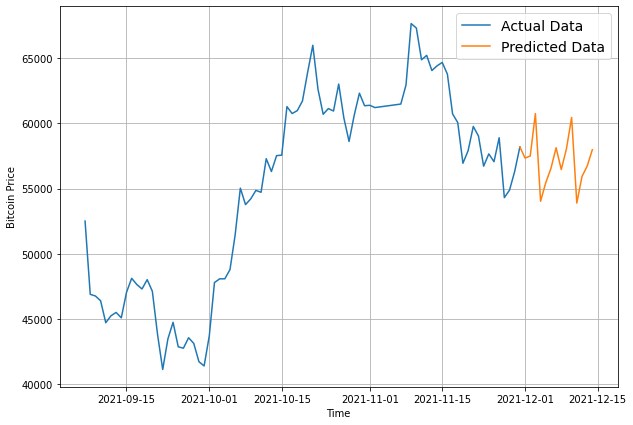

In [164]:
# Plot the graph for future predictions
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, prices, start=2500, format="-", label="Actual Data")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted Data");

In [166]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"model_1": model_1_results,
                              "model_2": model_2_results,
                              "model_3": model_3_results,
                              "model_4": model_4_results,
                              "model_5": model_5_results}).T
model_results

,MAE,MSE,RMSE,MAPE,MASE
model_1,1002.964050,2306467.25,1518.705811,2.676915,1.004335
model_2,1004.816406,2307650.50,1519.095215,2.686459,1.006190
model_3,999.557190,2288837.00,1512.890259,2.665525,1.000923
model_4,994.948792,2272665.50,1507.536255,2.657221,0.996309
model_5,993.764038,2277885.25,1509.266479,2.656745,0.995122
